In [ ]:
!pip install pandas
!pip install myhdl
!pip install myhdlpeek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 709 kB 5.2 MB/s 
  Created wheel for myhdl: filename=myhdl-0.11-py2.py3-none-any.whl size=152995 sha256=639335dd5210f9afa97a4821827ef81c4470fe04c3e2a1575b4d4e1cf2f7f436
  Stored in directory: /root/.cache/pip/wheels/5c/37/5c/b0263916c9d0557b5b9f95e5a6abeec5eab89a17daceb497a5
Successfully built myhdl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 62.0 MB/s 
  Created wheel for myhdlpeek: filename=myhdlpeek-0.0.10-py2.py3-none-any.whl size=20847 sha256=d534671bdf533bd22b17d91e43c6e5d63ad8eddec364013b332cacc3d882baa8
  Stored in directory: /root/.cache/pip/wheels/97/02/44/9466f9c0c1d29a36bf12b6fedda94b

In [ ]:
from myhdl import *
from myhdlpeek import Peeker
import pandas as pd

In [ ]:
df = pd.read_excel ('instss.xlsx')
insts=df.values.tolist()
rego=[5,2,1,4,5,6,7,8,4,3,5,2,1,4,5,6,7,8,4,3,5,2,1,4,5,6,7,8,4,3,5,1]
memory=[Signal(intbv(5))]*65500
Regfile=[]
for i in range(32) :
    Regfile+=[Signal(intbv(rego[i]))]
print (Regfile)
def nextpc(inp,out):
    @always(inp)
    def nextpc_behave():
        out.next=inp
    return nextpc_behave

def instmem(clk,insts,inp,out):
    @always(clk.posedge)
    def instmem_behave():
        if(inp<20):
            out.next=intbv(int(insts[inp][0],2))
    return instmem_behave

def decode(inst,op,rs,rt,rd,shamt,func,imm):
    @always(inst)
    def decode_behave():
        op.next=inst[32:26]
        rs.next=inst[26:21]
        rt.next=inst[21:16]
        rd.next=inst[16:11]
        shamt.next=inst[11:6]
        func.next=inst[6:]
        imm.next=inst[16:]

    return decode_behave

def control(op,func,Regdst,Regwrt,Alusrc,Aluop,Memwrt,Memred,Memtoreg,Brn):
    @always(op,func)
    def con_behave():
        if(op==int('000000',2)):
            Regdst.next=1
            Regwrt.next=1


            Memwrt.next=0
            Memred.next=0
            Alusrc.next=0
            Memtoreg.next=0
            Brn.next=0
            if(func==int('100000',2)):
                Aluop.next=int('010',2)
            elif(func==int('100010',2)):
                Aluop.next = int('110',2)
            elif (func == int('110110',2)):
                Aluop.next = int('000', 2)
            elif (func == int('110111',2)):
                Aluop.next = int('001', 2)
            elif (func == int('111000',2)):
                Aluop.next = int('011', 2)


        elif(op==int('100011',2)):
            Regdst.next=0
            Memwrt.next=0
            Brn.next=0
            Regwrt.next=1
            Alusrc.next=1
            Memred.next=1
            Memtoreg.next=1
            Aluop.next=int('010', 2)

        elif (op == int('101011',2)):
            Regdst.next=2
            Memtoreg.next = 2
            Memwrt.next=1
            Alusrc.next = 1
            Regwrt.next=0
            Brn.next=0
            Memred.next=0
            Aluop.next = int('010', 2)

        elif (op == int('000100',2)):
            Regdst.next=2
            Memtoreg.next = 2
            Brn.next = 1
            Regwrt.next=0
            Alusrc.next=0
            Memred.next=0
            Memwrt.next = 0
            Aluop.next = int('110', 2)

        elif (op == int('001000',2)):
            Regdst.next=0
            Memwrt.next=0
            Brn.next=0
            Memred.next=0
            Memtoreg.next=0
            Regwrt.next=0
            Alusrc.next = 1
            Aluop.next = int('010', 2)
        elif (op == int('100100',2)):
            Regdst.next= 0
            Memwrt.next= 0
            Brn.next= 0
            Memred.next= 0
            Memtoreg.next = 0
            Regwrt.next= 1
            Alusrc.next = 1
            Aluop.next = int('110', 2)

    return  con_behave

def RegFile(clk,Regfile,Regdest,rs,rt,rd,out1,out2,wrireg):
    @always_comb
    def regfile_behave():
      if(rt<32):
          out2.next=Regfile[rt[5:]][32:]
      if(rs<32):
          out1.next=Regfile[rs[5:]][32:]

      if(Regdest==0):
          wrireg.next=rt[5:]
      elif(Regdest==1):
          wrireg.next=rd[5:]

    return regfile_behave

def sign(imm,out):
    i=Signal(intbv(0))
    @always(imm)
    def sign_behave():
        if(imm[15]==False):
            out.next=imm[16:]
        else:
            i=intbv(twosCom_binDec('11111111111111111111111111111111',32))
            i[16:]=imm[16:]
            out.next=i[32:]

    return sign_behave

def alumux(in1,in2,alusrc,out):
    @always(in1,in2,alusrc)
    def alumux_behave():
        if(alusrc==0):
            out.next=in1
        elif(alusrc==1):
            out.next=in2
    return alumux_behave

def Alu(clk,in1,aluin,aluop,out):


    @always_comb
    def alu_behave():
        if(aluop == int('010',2)):
            out.next= in1+aluin
            zero.next =0
        elif(aluop == int('110',2)):
            out.next = in1 - aluin

        elif (aluop == int('000', 2)):
            out.next = in1 and aluin

        elif (aluop == int('001', 2)):
            out.next = in1 or aluin

        elif (aluop == int('011', 2)):
            out.next = in1 ^ aluin


    return alu_behave

def zeroo(aluout,aluop,zero):
    @always(aluout,aluop)
    def zero_behave():
        if(aluout.next==0 and aluop == int('110',2)):
            zero.next = 1
        else:
            zero.next = 0
    return zero_behave

def adder(clk,in1,in2,out):
    @always(clk.posedge)
    def add_behave():
        out.next=in1+in2
    return add_behave

def adder2(in1,in2,out):
    @always(in1,in2)
    def add_behave():
        out.next=in1+in2
    return add_behave

def shiftmux(clk,in1,in2,and1,and2,out):
    @always(clk.posedge)
    def shift_behave():
        if(and1==1 and and2==1):
            out.next=in2
        else:
            out.next=in1
    return shift_behave

def datamem(clk,in1,in2,memory,memwrt,memread,out):



    @always(clk.negedge)
    def mem_behave():
        if(memread==1):
            out.next=memory[in1]
        if(memwrt==1):
            memory[in1]=in2[32:]

    return  mem_behave

def wrtback(Regfile,in1,in2,memreg,regwrt,wrtreg):
    out=Signal(intbv(0))

    @always(in1,in2,memreg,regwrt,wrtreg)
    def wrtback_behave():
        if(memreg==0):
            out.next=in2
        elif(memreg==1):
            out.next=in1
    @always(out)
    def hah_behave():
        if(regwrt==1):
            Regfile[wrtreg]=out[32:]
    return wrtback_behave, hah_behave

[Signal(intbv(5)), Signal(intbv(2)), Signal(intbv(1)), Signal(intbv(4)), Signal(intbv(5)), Signal(intbv(6)), Signal(intbv(7)), Signal(intbv(8)), Signal(intbv(4)), Signal(intbv(3)), Signal(intbv(5)), Signal(intbv(2)), Signal(intbv(1)), Signal(intbv(4)), Signal(intbv(5)), Signal(intbv(6)), Signal(intbv(7)), Signal(intbv(8)), Signal(intbv(4)), Signal(intbv(3)), Signal(intbv(5)), Signal(intbv(2)), Signal(intbv(1)), Signal(intbv(4)), Signal(intbv(5)), Signal(intbv(6)), Signal(intbv(7)), Signal(intbv(8)), Signal(intbv(4)), Signal(intbv(3)), Signal(intbv(5)), Signal(intbv(1))]


In [ ]:
clk=Signal(bool(0))
imm=Signal(intbv(0)[16:])
pc=Signal(intbv(0))
inst=Signal(intbv(0)[32:])
op=Signal(intbv(0))
rs=Signal(intbv(0))
shamt=Signal(intbv(0))
rt=Signal(intbv(0))
rd=Signal(intbv(0))
func=Signal(intbv(0))
Regdest=Signal(intbv(0))
Regwrt=Signal(intbv(0))
Alusrc=Signal(intbv(0))
Aluop=Signal(intbv(0))
Memwrt=Signal(intbv(0))
Memread=Signal(intbv(0))
Memtoreg=Signal(intbv(0))
Brn=Signal(intbv(0))
read1=Signal(intbv(0))
read2=Signal(intbv(0))
wrtreg=Signal(intbv(0))
extendout=Signal(intbv(0)[32:])
aluout=Signal(intbv(0))
zero=Signal(intbv(0))
readdata=Signal(intbv(0))
pcint1=Signal(intbv(0))
pcint2=Signal(intbv(0))
pcin=Signal(intbv(0))
outmem=Signal(intbv(0))
aluin=Signal(intbv(0))

Peeker(clk, 'clk')
Peeker(pc, 'pc')
Peeker(inst, 'inst')
Peeker(read1, 'read1')         # Add a Peeker to the a input.
Peeker(read2, 'read2')         # Add a Peeker to the b input.
Peeker(extendout, 'extendout')
Peeker(Aluop, 'Aluop')
Peeker(Alusrc, 'Alusrc')

Peeker(aluout, 'aluout')
Peeker(zero, 'zero')


Peeker(op, 'op')
Peeker(rs, 'rs')
Peeker(rt, 'rt')
Peeker(rd, 'rd')
Peeker(shamt, 'shamt')
Peeker(func, 'func')
Peeker(Regdest, 'Regdest')
Peeker(Regwrt, 'Regwrt')

Peeker(Memwrt, 'Memwrt')
Peeker(Memread, 'Memread')
Peeker(Memtoreg, 'Memtoreg')
Peeker(Brn, 'Brn')
Peeker(readdata, 'readdata')
Peeker(pcint1, 'pcint1')
Peeker(wrtreg, 'wrtreg')
Peeker(pcint2, 'pcint2')
Peeker(pcin, 'pcin')
Peeker(outmem, 'outmem')
Peeker(aluin, 'aluin')
Peeker(imm,'imm')

In [ ]:
def twosCom_binDec(bin, digit):
        while len(bin)<digit :
                bin = '0'+bin
        if bin[0] == '0':
                return int(bin, 2)
        else:
                return -1 * (int(''.join('1' if x == '0' else '0' for x in bin), 2) + 1)

<class 'myhdl.StopSimulation'>: No more events


Time,Aluop,Alusrc,Brn,Memread,Memtoreg,Memwrt,Regdest,Regwrt,aluin,aluout,clk,extendout,func,imm,inst,op,outmem,pc,pcin,pcint1,pcint2,rd,read1,read2,readdata,rs,rt,shamt,wrtreg,zero
0,2,0,0,0,0,0,1,1,5,6,True,00006820,20,6820,018a6820,0,0,0,0,1,6821,d,1,5,0,c,a,0,d,0
1,2,0,0,0,0,0,1,1,5,6,False,00006820,20,6820,018a6820,0,0,0,0,1,6821,d,1,5,0,c,a,0,d,0
2,2,0,0,0,0,0,1,1,5,6,True,00006820,20,6820,018a6820,0,0,1,1,1,6821,d,1,5,0,c,a,0,d,0
3,2,0,0,0,0,0,1,1,5,6,False,00006820,20,6820,018a6820,0,0,1,1,1,6821,d,1,5,0,c,a,0,d,0
4,6,0,0,0,0,0,1,1,6,0,True,00007822,22,7822,01ad7822,0,0,1,1,2,7824,f,6,6,0,d,d,0,f,1
5,6,0,0,0,0,0,1,1,6,0,False,00007822,22,7822,01ad7822,0,0,1,1,2,7824,f,6,6,0,d,d,0,f,1
6,6,0,0,0,0,0,1,1,6,0,True,00007822,22,7822,01ad7822,0,0,2,2,2,7824,f,6,6,0,d,d,0,f,1
7,6,0,0,0,0,0,1,1,6,0,False,00007822,22,7822,01ad7822,0,0,2,2,2,7824,f,6,6,0,d,d,0,f,1
8,2,1,0,0,0,0,0,0,111,117,True,00000111,11,0111,23350111,8,0,2,2,3,114,0,6,2,0,19,15,4,15,0
9,2,1,0,0,0,0,0,0,111,117,False,00000111,11,0111,23350111,8,0,2,2,3,114,0,6,2,0,19,15,4,15,0


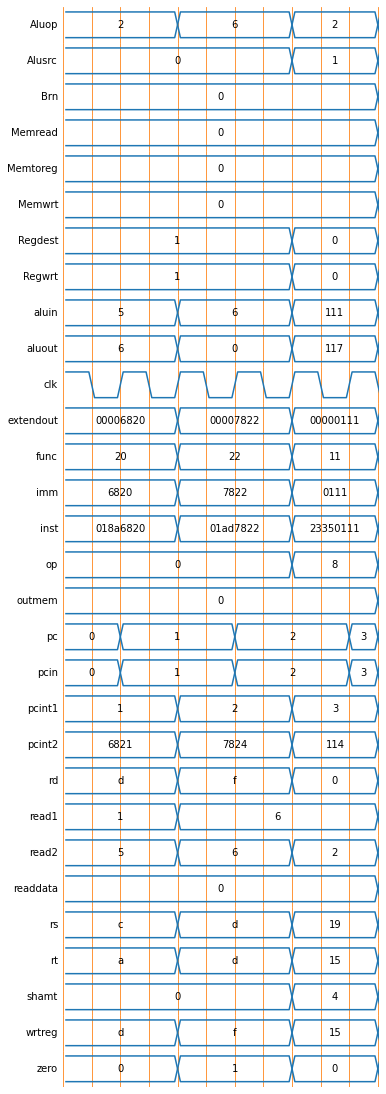

In [ ]:
instmem_inst = instmem(clk,insts,pc,inst)
dec_inst = decode(inst,op,rs,rt,rd,shamt,func,imm)
con_inst = control(op,func,Regdest,Regwrt,Alusrc,Aluop,Memwrt,Memread,Memtoreg,Brn)
reg_inst = RegFile(clk,Regfile,Regdest,rs,rt,rd,read1,read2,wrtreg)
sign_inst = sign(imm,extendout)
alumux_inst = alumux(read2,extendout,Alusrc,aluin)
alu_inst = Alu(clk,read1,aluin,Aluop,aluout)
zero_inst = zeroo(aluout,Aluop,zero)
add1_inst = adder(clk,pc,Signal(intbv(1)),pcint1)
add2_inst = adder2(pcint1,extendout,pcint2)
shiftmux_inst = shiftmux(clk,pcint1,pcint2,Brn,zero,pcin)
datamem_inst = datamem(clk,aluout,read2,memory,Memwrt,Memread,outmem)
wrtback_inst = wrtback(Regfile,outmem,aluout,Memtoreg,Regwrt,wrtreg)
pc_inst = nextpc(pcin,pc)

def test():
    for i in range(12):

        clk.next = not clk
        yield delay(1)


#sim = Simulation(mipss,test(), *Peeker.instances())
sim = Simulation(instmem_inst,dec_inst,con_inst,reg_inst,sign_inst,alumux_inst,alu_inst,zero_inst,add1_inst,add2_inst,shiftmux_inst,datamem_inst,wrtback_inst,pc_inst, test(), *Peeker.instances())

# Run the simulation.
sim.run()
Peeker.show_waveforms()
Peeker.to_html_table()
Peeker.clear()

In [ ]:
print(Regfile[13])

00000006


In [ ]:
print(Regfile[25])

6


In [ ]:
print(Regfile[24])


5


In [ ]:
print(memory[59])

5
